### 根据老师上课讲解修改版本

##### preprocessing

In [1]:
# read data
import pandas as pd
import numpy as np

dir = 'data/01_redHat/'
print('load people.csv..')
people = pd.read_csv(dir+'people.csv',
                    dtype={'people_id':np.str,
                           'char_38':np.int32},
                    parse_dates=['date'])
print('load train.csv..')
train = pd.read_csv(dir+'act_train.csv',
                   dtype={'people_id':np.str,
                          'activity_id':np.str,
                          'outcome':np.int8},
                   parse_dates=['date'])
print('load test.csv..')
test = pd.read_csv(dir+'act_test.csv',
                  dtype={'people_id':np.str,
                         'activity_id':np.str},
                  parse_dates=['date'])
print('Process tables..')

load people.csv..
load train.csv..
load test.csv..
Process tables..


In [2]:
# 转换日期
for table in [train, test]:
    table['year'] = table['date'].dt.year
    table['month'] = table['date'].dt.month
    table['day'] = table['date'].dt.day
    table.drop('date', axis=1, inplace=True)
    table['activity_category'] = table['activity_category'].str.lstrip('type ').astype(np.int32)
    
people['year'] = people['date'].dt.year
people['month'] = people['date'].dt.month
people['day'] = people['date'].dt.day
people.drop('date', axis=1, inplace=True)

# 将特征只留下数值。这个其实和label encoder做的事是一样的
people['group_1'] = people['group_1'].str.lstrip('group ').astype(np.int32)
for i in range(1,10):
    people['char_'+str(i)] = people['char_'+str(i)].str.lstrip('type ').astype(np.int32)
for i in range(10, 38):
    people['char_'+str(i)] = people['char_'+str(i)].astype(np.int32)

In [3]:
# 删除掉不需要的列
train_1 = train.copy()
test_1 = test.copy()
for i in range(1,11):
    train_1.drop('char_'+str(i), axis=1, inplace=True)
    test_1.drop('char_'+str(i), axis=1, inplace=True)

In [4]:
# Merge
print('Merge..')
train_1 = pd.merge(train_1, people, how='left', on='people_id', left_index=True)
test_1 = pd.merge(test_1, people, how='left', on='people_id', left_index=True)

Merge..


In [5]:
# features，train和test都有的特征才是有效feature
trainval = list(train_1.columns.values)
testval = list(test_1.columns.values)
output = list(set(trainval) & set(testval))
output.remove('people_id')
output.remove('activity_id')
features = sorted(output)

##### train

In [6]:
target = 'outcome'
test_size = 0.4
random_state = 0
from sklearn.model_selection import train_test_split
x_train, x_val = train_test_split(train_1, test_size=test_size, random_state=random_state)

y_train = x_train[target]
x_train = x_train[features]
y_val = x_val[target]
x_val = x_val[features]

In [7]:
# 逻辑回归
from sklearn.linear_model import LogisticRegression
C = 1e3
solver = 'liblinear'
logreg = LogisticRegression(C=C, solver=solver).fit(x_train, y_train)
#logreg.fit(x_train, y_train)

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import auc

check = logreg.predict(x_val)
score = roc_auc_score(y_val.values, check)
print('Check error value: {:.6f}'.format(score))

Check error value: 0.828943


In [13]:
y_val.values[0:20]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0],
      dtype=int8)

In [14]:
check[0:20]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1],
      dtype=int8)

[0.         0.20151937 1.        ]
[0.         0.85940599 1.        ]


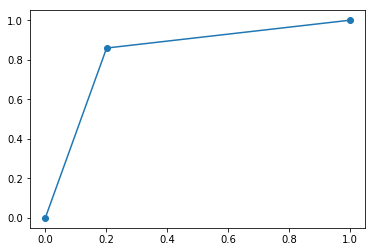

In [15]:
%matplotlib inline
fpr, tpr, thresholds = metrics.roc_curve(y_val.values, check, pos_label=1)
print(fpr)
print(tpr)

#画图
plt.plot(fpr, tpr, marker = 'o')
plt.show()

In [ ]:
# XGBOOST
import xgboost as xgb
#from xgboost import XGBClassifier as xgb
eta = 0.3
max_depth = 5
subsample = 0.5
colsample_bytree = 1
#start_time = time.time()

print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
params = {
    "objective": "binary:logistic",
    "booster" : "gbtree",
    "eval_metric": "auc",
    "eta": eta,
    "tree_method": 'exact',
    "max_depth": max_depth,
    "subsample": subsample,
    "colsample_bytree": colsample_bytree,
    "silent": 1,
    "seed": random_state,
}
num_boost_round = 900
early_stopping_rounds = 10

dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_val, y_val)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

print("Validating...")
check = gbm.predict(xgb.DMatrix(X_valid[features]), ntree_limit=gbm.best_iteration+1)
score = roc_auc_score(x_valid[target].values, check)
print('Check error value: {:.6f}'.format(score))

XGBoost params. ETA: 0.3, MAX_DEPTH: 5, SUBSAMPLE: 0.5, COLSAMPLE_BY_TREE: 1
[0]	train-auc:0.915277	eval-auc:0.914908
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.921167	eval-auc:0.92091
[2]	train-auc:0.923971	eval-auc:0.923725
[3]	train-auc:0.928789	eval-auc:0.92856
[4]	train-auc:0.929944	eval-auc:0.929846
[5]	train-auc:0.930416	eval-auc:0.930334
[6]	train-auc:0.931346	eval-auc:0.931292
[7]	train-auc:0.932368	eval-auc:0.932248
[8]	train-auc:0.933745	eval-auc:0.933505
[9]	train-auc:0.934841	eval-auc:0.934634
[10]	train-auc:0.935299	eval-auc:0.935066
[11]	train-auc:0.936	eval-auc:0.935747
[12]	train-auc:0.936459	eval-auc:0.936204
[13]	train-auc:0.9375	eval-auc:0.937293
[14]	train-auc:0.939404	eval-auc:0.939221
[15]	train-auc:0.939722	eval-auc:0.939555
[16]	train-auc:0.940066	eval-auc:0.939907
[17]	train-auc:0.940706	eval-auc:0.940584
[18]	train-auc:0.941121	eval-auc:0.940989
[

[190]	train-auc:0.980134	eval-auc:0.979081
[191]	train-auc:0.980211	eval-auc:0.97915
[192]	train-auc:0.980301	eval-auc:0.979246
[193]	train-auc:0.980369	eval-auc:0.979314
[194]	train-auc:0.980427	eval-auc:0.979367
[195]	train-auc:0.980523	eval-auc:0.979453
[196]	train-auc:0.980597	eval-auc:0.979518
[197]	train-auc:0.980659	eval-auc:0.979569
[198]	train-auc:0.980723	eval-auc:0.979627
[199]	train-auc:0.980733	eval-auc:0.979636
[200]	train-auc:0.980792	eval-auc:0.979691
[201]	train-auc:0.98089	eval-auc:0.979788
[202]	train-auc:0.980954	eval-auc:0.979857
[203]	train-auc:0.981013	eval-auc:0.979907
[204]	train-auc:0.981151	eval-auc:0.980061
[205]	train-auc:0.981157	eval-auc:0.980066
[206]	train-auc:0.981229	eval-auc:0.980131
[207]	train-auc:0.981299	eval-auc:0.980206
[208]	train-auc:0.981343	eval-auc:0.980247
[209]	train-auc:0.981372	eval-auc:0.980271
[210]	train-auc:0.981463	eval-auc:0.980368
[211]	train-auc:0.981525	eval-auc:0.980434
[212]	train-auc:0.981521	eval-auc:0.980431
[213]	train-a

[382]	train-auc:0.988823	eval-auc:0.987476
[383]	train-auc:0.988832	eval-auc:0.987484
[384]	train-auc:0.98886	eval-auc:0.987508
[385]	train-auc:0.988865	eval-auc:0.987514
[386]	train-auc:0.9889	eval-auc:0.987548
[387]	train-auc:0.988907	eval-auc:0.987556
[388]	train-auc:0.988935	eval-auc:0.98758
[389]	train-auc:0.988982	eval-auc:0.987622
[390]	train-auc:0.98899	eval-auc:0.987628
[391]	train-auc:0.98899	eval-auc:0.987624
[392]	train-auc:0.98902	eval-auc:0.987645
[393]	train-auc:0.989051	eval-auc:0.987675
[394]	train-auc:0.989083	eval-auc:0.987711
[395]	train-auc:0.989111	eval-auc:0.987739
[396]	train-auc:0.989145	eval-auc:0.987775
[397]	train-auc:0.989168	eval-auc:0.987804
[398]	train-auc:0.98919	eval-auc:0.987828
[399]	train-auc:0.989217	eval-auc:0.987853
[400]	train-auc:0.989224	eval-auc:0.987858
[401]	train-auc:0.989258	eval-auc:0.987892
[402]	train-auc:0.989303	eval-auc:0.987933
[403]	train-auc:0.98931	eval-auc:0.987939
[404]	train-auc:0.98933	eval-auc:0.987954
[405]	train-auc:0.989

[574]	train-auc:0.992406	eval-auc:0.991004
[575]	train-auc:0.992425	eval-auc:0.99103
[576]	train-auc:0.992443	eval-auc:0.991044
[577]	train-auc:0.992465	eval-auc:0.991067
[578]	train-auc:0.992473	eval-auc:0.991079
[579]	train-auc:0.992474	eval-auc:0.99108
[580]	train-auc:0.992486	eval-auc:0.991091
[581]	train-auc:0.9925	eval-auc:0.991108
[582]	train-auc:0.992533	eval-auc:0.991141
[583]	train-auc:0.992537	eval-auc:0.991142
[584]	train-auc:0.992558	eval-auc:0.991169
[585]	train-auc:0.992575	eval-auc:0.991181
[586]	train-auc:0.992584	eval-auc:0.991193
[587]	train-auc:0.992599	eval-auc:0.991212
[588]	train-auc:0.99262	eval-auc:0.991232
[589]	train-auc:0.992634	eval-auc:0.991243
[590]	train-auc:0.992651	eval-auc:0.991256
[591]	train-auc:0.992657	eval-auc:0.991261
[592]	train-auc:0.992666	eval-auc:0.991266
[593]	train-auc:0.992689	eval-auc:0.99129
[594]	train-auc:0.9927	eval-auc:0.991297
[595]	train-auc:0.992718	eval-auc:0.991317
[596]	train-auc:0.992724	eval-auc:0.99132
[597]	train-auc:0.99